## Ejercicio

Utilizar otro dataset y poner en práctica la predicción de próxima palabra

In [1]:
!pip install --upgrade tensorflow==2.8.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 668.3 MB 16 kB/s 
     |████████████████████████████████| 462 kB 5.5 MB/s 
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.8.2+zzzcolab20220719082949
    Uninstalling tensorflow-2.8.2+zzzcolab20220719082949:
      Successfully uninstalled tensorflow-2.8.2+zzzcolab20220719082949


In [2]:
import tensorflow
print(tensorflow.__version__)

2.8.0


In [3]:
import random
import io
import pickle

import numpy as np
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout

In [4]:
# Descargar la carpeta de dataset
import os
import platform
if os.access('./songs_dataset', os.F_OK) is False:
    if os.access('songs_dataset.zip', os.F_OK) is False:
        if platform.system() == 'Windows':
            !curl https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip -o songs_dataset.zip
        else:
            !wget songs_dataset.zip https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/raw/main/datasets/songs_dataset.zip
    !unzip -q songs_dataset.zip   
else:
    print("El dataset ya se encuentra descargado")

--2022-08-23 12:20:46--  http://songs_dataset.zip/
Resolving songs_dataset.zip (songs_dataset.zip)... failed: Name or service not known.
wget: unable to resolve host address ‘songs_dataset.zip’
--2022-08-23 12:20:46--  https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/raw/main/datasets/songs_dataset.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip [following]
--2022-08-23 12:20:46--  https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.

In [77]:
# Armar el dataset utilizando salto de línea para separar las oraciones/docs
df = pd.read_csv('courtney_barnett.txt', sep='/n', header=None)
df.head()

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


,0
0,In the morning I’m slow. I drag a chair over t...
1,Well time is money and money is no man’s frien...
2,The day begins to shine. The parent teaches th...
3,Well time is money and money is no man’s frien...
4,Next door the kids run amok. The mother scream...


In [58]:
from nltk.tokenize import sent_tokenize
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


['God is Great!', 'I won a lottery.']


In [74]:
sentences_rows = []
for i,row in df.iterrows():
   sentences_rows += sent_tokenize(row[0])
  
len(sentences_rows)

921

In [78]:
df = pd.DataFrame(sentences_rows)
print(df.shape)
df.head()

(921, 1)


,0
0,In the morning I’m slow.
1,I drag a chair over to the window.
2,And I watch what’s going on.
3,A garbage truck tiptoes along the road.
4,Light a candle for the suffering.


In [79]:
from keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from keras.preprocessing.text import text_to_word_sequence # equivalente a word_teokenize de nltk
from keras.preprocessing.sequence import pad_sequences # se utilizará para padding

# largo de la secuencia, incluye seq input + word output
train_len = 4

In [80]:
# Ejemplo de como transformar una oración a tokens usando keras
text = df.loc[0,0]
text

'In the morning I’m slow.'

In [81]:
tokens = text_to_word_sequence(text) # entran oraciones -> salen vectores de N posiciones (tokens)
tokens

['in', 'the', 'morning', 'i’m', 'slow']

In [82]:
# Recorrer todas las filas y transformar las oraciones
# en secuencias de palabras
sentence_tokens = []
for _, row in df[:None].iterrows():
    sentence_tokens.append(text_to_word_sequence(row[0]))

In [83]:
# Demos un vistazo
sentence_tokens[:2]

[['in', 'the', 'morning', 'i’m', 'slow'],
 ['i', 'drag', 'a', 'chair', 'over', 'to', 'the', 'window']]

In [84]:
# Código para hacer el desfazaje de las palabras
# según el train_len
text_sequences = []

for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [85]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences

[['in', 'the', 'morning', 'i’m']]

In [87]:
tok = Tokenizer() 

# El tokeinzer "aprende" las palabras que se usaran
# Se construye (fit) una vez por proyecto, se aplica N veces (tal cual un encoder)
tok.fit_on_texts(text_sequences) 

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

In [88]:
# Ahora sequences tiene los números "ID", largo 4
sequences

[[1, 2, 3, 4]]

In [89]:
# Cantidad de casos (doc) de entrada
print(tok.document_count)

1


In [90]:
# Cantidad de veces que aparece cada palabra
print(len(tok.word_counts))

4


In [91]:
# El índice para cada palabra
# El sistema las ordena de las más populares a las menos populares
print(tok.word_index)

{'in': 1, 'the': 2, 'morning': 3, 'i’m': 4}


In [92]:
# Cantidad de veces quea aparece cada palabra en cada "documento"
# (1 documento = 1 caso de entrada)
print(tok.word_docs)

defaultdict(<class 'int'>, {'morning': 1, 'the': 1, 'in': 1, 'i’m': 1})


### Preprocesamiento completo

In [93]:
# Vistazo a las primeras filas
df.loc[:15,0]

0                              In the morning I’m slow.
1                    I drag a chair over to the window.
2                          And I watch what’s going on.
3               A garbage truck tiptoes along the road.
4                     Light a candle for the suffering.
5                    Send my best wishes with the wind.
6     All our candles, hopes n prayers, though well-...
7                       I might change my sheets today.
8      Well time is money and money is no man’s friend.
9     And all eyes on the pavement, I’m not gonna to...
10                             The day begins to shine.
11    The parent teaches the child how to ride the b...
12                 Two dogs entangle, everybody smiles.
13    The pair across the street; one’s up the ladde...
14        What’s the point, it looks fine from up here.
15     Well time is money and money is no man’s friend.
Name: 0, dtype: object

In [95]:
# Concatenamos todos los rows en un solo valor
corpus = df.apply(lambda row: ' '.join(row.values.astype(str)), axis=0)[0]
corpus

'In the morning I’m slow. I drag a chair over to the window. And I watch what’s going on. A garbage truck tiptoes along the road. Light a candle for the suffering. Send my best wishes with the wind. All our candles, hopes n prayers, though well-meaning they don’t mean a thing, unless we see some change. I might change my sheets today. Well time is money and money is no man’s friend. And all eyes on the pavement, I’m not gonna touch ya don’t worry so much about it. The day begins to shine. The parent teaches the child how to ride the bike wobbles side to side. Two dogs entangle, everybody smiles. The pair across the street; one’s up the ladder and one’s on their knees, painting the faded brick. What’s the point, it looks fine from up here. Well time is money and money is no man’s friend. And all eyes on the pavement, I’m not gonna touch ya don’t worry so much about it. I’m just waiting for the day to become night. Next door the kids run amok. The mother screams “don’t you ever shut-up?”

In [100]:
# Transformar el corpus a tokens
tokens=text_to_word_sequence(corpus)
# Vistazo general de los primeros tokens

tokens[:20]

['in',
 'the',
 'morning',
 'i’m',
 'slow',
 'i',
 'drag',
 'a',
 'chair',
 'over',
 'to',
 'the',
 'window',
 'and',
 'i',
 'watch',
 'what’s',
 'going',
 'on',
 'a']

In [101]:
print("Cantidad de tokens en el corpus:", len(tokens))

Cantidad de tokens en el corpus: 8474


In [102]:
# Código para hacer el desfazaje de las palabras
# según el train_len
text_sequences = []
for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [103]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences[:20]

[['in', 'the', 'morning', 'i’m'],
 ['the', 'morning', 'i’m', 'slow'],
 ['morning', 'i’m', 'slow', 'i'],
 ['i’m', 'slow', 'i', 'drag'],
 ['slow', 'i', 'drag', 'a'],
 ['i', 'drag', 'a', 'chair'],
 ['drag', 'a', 'chair', 'over'],
 ['a', 'chair', 'over', 'to'],
 ['chair', 'over', 'to', 'the'],
 ['over', 'to', 'the', 'window'],
 ['to', 'the', 'window', 'and'],
 ['the', 'window', 'and', 'i'],
 ['window', 'and', 'i', 'watch'],
 ['and', 'i', 'watch', 'what’s'],
 ['i', 'watch', 'what’s', 'going'],
 ['watch', 'what’s', 'going', 'on'],
 ['what’s', 'going', 'on', 'a'],
 ['going', 'on', 'a', 'garbage'],
 ['on', 'a', 'garbage', 'truck'],
 ['a', 'garbage', 'truck', 'tiptoes']]

In [105]:
# Proceso de tokenizacion
tok = Tokenizer() 
tok.fit_on_texts(text_sequences) 

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

# Damos un vistazo
sequences[:20]

[[13, 3, 231, 7],
 [3, 231, 7, 355],
 [231, 7, 355, 1],
 [7, 355, 1, 721],
 [355, 1, 721, 4],
 [1, 721, 4, 722],
 [721, 4, 722, 103],
 [4, 722, 103, 5],
 [722, 103, 5, 3],
 [103, 5, 3, 723],
 [5, 3, 723, 6],
 [3, 723, 6, 1],
 [723, 6, 1, 288],
 [6, 1, 288, 289],
 [1, 288, 289, 111],
 [288, 289, 111, 9],
 [289, 111, 9, 4],
 [111, 9, 4, 724],
 [9, 4, 724, 474],
 [4, 724, 474, 725]]

In [106]:
print("Cantidad de rows del dataset:", len(sequences))

Cantidad de rows del dataset: 8470


### Input y target

In [107]:
# Con numpy es muy fácil realizar el slicing de vectores
ex = np.array([[1,2,3,4],[5,6,7,8]])
ex

array([[1, 2, 3, 4],
       [5, 6, 7, 8]])

In [108]:
# Con numpy es muy fácil realizar el slicing de vectores
print("Dimension:", ex.shape)
print("Todos los elementos:", ex)
print("Todos los elementos menos el último:", ex[:, :-1])

Dimension: (2, 4)
Todos los elementos: [[1 2 3 4]
 [5 6 7 8]]
Todos los elementos menos el último: [[1 2 3]
 [5 6 7]]


In [109]:
input = ex[:,:-1] # todos los rows, menos la ultima col
target = ex[:, -1] # última col de cada row

print("Input:", input)
print("Target:", target)

Input: [[1 2 3]
 [5 6 7]]
Target: [4 8]


In [110]:
arr_sequences = np.array(sequences)
x_data = arr_sequences[:,:-1]
y_data_int = arr_sequences[:,-1] # aún falta el oneHotEncoder

print(x_data.shape)
print(y_data_int.shape)

(8470, 3)
(8470,)


In [113]:
# Palabras del vocabulario
tok.index_word

{1: 'i',
 2: 'you',
 3: 'the',
 4: 'a',
 5: 'to',
 6: 'and',
 7: 'i’m',
 8: 'it',
 9: 'on',
 10: 'me',
 11: 'my',
 12: 'your',
 13: 'in',
 14: 'don’t',
 15: 'of',
 16: 'that',
 17: 'all',
 18: 'you’re',
 19: 'what',
 20: 'it’s',
 21: 'for',
 22: 'we',
 23: 'know',
 24: 'got',
 25: 'but',
 26: 'so',
 27: 'be',
 28: 'not',
 29: 'just',
 30: 'with',
 31: 'from',
 32: 'say',
 33: 'are',
 34: 'like',
 35: 'at',
 36: 'get',
 37: 'up',
 38: 'no',
 39: 'go',
 40: 'oh',
 41: 'if',
 42: 'i’ll',
 43: 'is',
 44: 'time',
 45: 'when',
 46: 'see',
 47: 'want',
 48: 'out',
 49: 'tell',
 50: 'wanna',
 51: 'down',
 52: 'feel',
 53: 'never',
 54: 'have',
 55: 'some',
 56: 'can',
 57: 'was',
 58: 'day',
 59: 'thinking',
 60: 'an',
 61: 'this',
 62: 'too',
 63: 'little',
 64: 'really',
 65: 'take',
 66: 'do',
 67: 'gonna',
 68: 'away',
 69: 'same',
 70: 'as',
 71: 'eye',
 72: 'n',
 73: 'well',
 74: 'hear',
 75: 'can’t',
 76: 'need',
 77: 'think',
 78: 'they',
 79: 'here',
 80: 'been',
 81: 'than',
 82: 'mu

In [114]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

1788

In [115]:
y_data_int_offset = y_data_int - 1
y_data = to_categorical(y_data_int_offset, num_classes=vocab_size) 
y_data.shape

(8470, 1788)

### Entrenar el modelo

In [116]:
# largo de la secuencia de entrada
input_seq_len = x_data.shape[1] 
input_seq_len

3

In [117]:
# Largo del vector de salida --> vocab_size
output_size = vocab_size
output_size

1788

In [121]:
model = Sequential()

# Embedding:
# input_seq_len = 3 --> ingreso 3 palabras
# input_dim = vocab_size --> 1628 palabras distintas
# output_dim = 5 --> crear embeddings de tamaño 3 (tamaño variable y ajustable)
model.add(Embedding(input_dim=vocab_size+1, output_dim=5, input_length=input_seq_len))

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64)) # La última capa LSTM no lleva return_sequences
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida vuelve al espacio de 1628 palabras posibles
model.add(Dense(vocab_size, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 3, 5)              8945      
                                                                 
 lstm_4 (LSTM)               (None, 3, 64)             17920     
                                                                 
 dropout_2 (Dropout)         (None, 3, 64)             0         
                                                                 
 lstm_5 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 1788)             

In [122]:
hist = model.fit(x_data, y_data, epochs=100, validation_split=0.2)

Epoch 1/100
212/212 [==============================] - 10s 28ms/step - loss: 6.5518 - accuracy: 0.0385 - val_loss: 6.5382 - val_accuracy: 0.0455
Epoch 2/100
212/212 [==============================] - 3s 12ms/step - loss: 6.0267 - accuracy: 0.0424 - val_loss: 6.7360 - val_accuracy: 0.0455
Epoch 3/100
212/212 [==============================] - 3s 12ms/step - loss: 5.9634 - accuracy: 0.0434 - val_loss: 6.9944 - val_accuracy: 0.0466
Epoch 4/100
212/212 [==============================] - 3s 12ms/step - loss: 5.9308 - accuracy: 0.0431 - val_loss: 7.0989 - val_accuracy: 0.0478
Epoch 5/100
212/212 [==============================] - 2s 11ms/step - loss: 5.9011 - accuracy: 0.0452 - val_loss: 7.1515 - val_accuracy: 0.0455
Epoch 6/100
212/212 [==============================] - 2s 12ms/step - loss: 5.8739 - accuracy: 0.0455 - val_loss: 7.2895 - val_accuracy: 0.0496
Epoch 7/100
212/212 [==============================] - 2s 12ms/step - loss: 5.8288 - accuracy: 0.0413 - val_loss: 7.3142 - val_accuracy

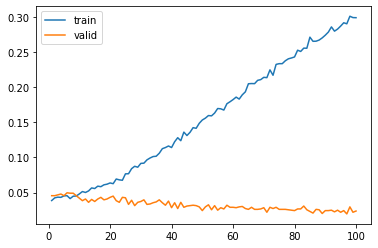

In [123]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

OBS:
* En general no se obtiene buen accuracy para la prediccion de proxima palabra.

In [124]:
# Keras pad_sequences
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
# Si la secuencia de entrada supera al input_seq_len (3) se trunca
# Si la secuencia es más corta se agregna ceros al comienzo

In [125]:
# Se utilizará gradio para ensayar el modelo
# Herramienta poderosa para crear interfaces rápidas para ensayar modelos
# https://gradio.app/
import sys
!{sys.executable} -m pip install gradio --quiet

     |████████████████████████████████| 6.1 MB 5.2 MB/s 
     |████████████████████████████████| 84 kB 2.7 MB/s 
     |████████████████████████████████| 57 kB 4.3 MB/s 
     |████████████████████████████████| 275 kB 33.8 MB/s 
     |████████████████████████████████| 54 kB 2.8 MB/s 
     |████████████████████████████████| 112 kB 53.9 MB/s 
     |████████████████████████████████| 212 kB 73.6 MB/s 
     |████████████████████████████████| 54 kB 2.4 MB/s 
     |████████████████████████████████| 2.3 MB 45.1 MB/s 
     |████████████████████████████████| 84 kB 2.9 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
     |████████████████████████████████| 80 kB 7.8 MB/s 
     |████████████████████████████████| 68 kB 5.8 MB/s 
     |████████████████████████████████| 43 kB 1.6 MB/s 
     |████████████████████████████████| 4.1 MB 26.0 MB/s 
     |████████████████████████████████| 62 kB 771 kB/s 
     |████████████████████████████████| 856 kB 46.2 MB/s 


In [126]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=3, padding='pre')
    
    # Predicción softmax
    y_hat = model.predict(encoded).argmax(axis=-1)

    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text",
    layout="vertical")

iface.launch(debug=True)

/usr/local/lib/python3.7/dist-packages/gradio/deprecation.py:40: UserWarning: `layout` parameter is deprecated, and it has no effect
  warnings.warn(value)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://36603.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces: https://huggingface.co/spaces


Keyboard interruption in main thread... closing server.


(<gradio.routes.App at 0x7fbc32a09f90>,
 'http://127.0.0.1:7860/',
 'https://36603.gradio.app')

### Generación de secuencias nuevas

In [127]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = tokenizer.texts_to_sequences([output_text])[0]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')
		
		# Predicción softmax
        y_hat = model.predict(encoded).argmax(axis=-1)
		# Vamos concatenando las predicciones
        out_word = ''

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por le modelo
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

		# Agrego las palabras a la frase predicha
        output_text += ' ' + out_word
    return output_text

In [140]:
input_text=["I don't hear from", "I don't wanna go", "I don’t know you", "I don’t know quite", "I much prefer swimming to"]
for i in input_text:
  print(generate_seq(model, tok, i, max_length=3, n_words=2))

I don't hear from you give
I don't wanna go what apart
I don’t know you no we
I don’t know quite looking and
I much prefer swimming to foggy and
